In [1]:
# ELM ON OTHER CLASSES

import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as mpatches
import tensorflow as tf
from random import shuffle
import librosa
import pickle


In [2]:
# LOAD PROCESSED DATA
ELM_Training_Data, ELM_Training_Label = pickle.load(open('preprocessedAudio_Training_CIFAR.p', mode='rb'))
ELM_Validation_Data, ELM_Validation_Label = pickle.load(open('preprocessedAudio_Validation_CIFAR.p', mode='rb'))
numberOfClasses = len(ELM_Training_Label[0])
print("training samples")
print(len(ELM_Training_Data))
print("validation samples")
print(len(ELM_Validation_Data))

training samples
19860
validation samples
3504


In [3]:
# Remove part of data
perc = 0.38
newTrain = int(len(ELM_Training_Data) * perc)
newValid = int(len(ELM_Validation_Data) * perc)

ELM_Training_Data, ELM_Training_Label = ELM_Training_Data[:newTrain],ELM_Training_Label[:newTrain]
ELM_Validation_Data, ELM_Validation_Label = ELM_Validation_Data[:newValid],ELM_Validation_Label[:newValid]
numberOfClasses = len(ELM_Training_Label[0])
print("training samples")
print(len(ELM_Training_Data))
print("validation samples")
print(len(ELM_Validation_Data))

# Get the total number of classes from cut data
newPercData = np.divide(np.sum(ELM_Training_Label, axis=0),len(ELM_Training_Label))*100
['{:.4f}%'.format(i) for i in newPercData] 

training samples
7546
validation samples
1331


['7.3549%',
 '7.6332%',
 '6.9706%',
 '7.3019%',
 '10.8004%',
 '7.5934%',
 '7.2356%',
 '10.1378%',
 '9.9258%',
 '9.8860%',
 '7.5802%',
 '7.5802%']

In [4]:
# LOAD THE PRETRAINED CNN AND FEED THE CIFAR DATA THROUGH
import time
tf.set_random_seed(2018)

model_path = './audio_classificationMNIST'
loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    # Load model
    loader = tf.train.import_meta_graph(model_path + '.meta')
    loader.restore(sess, model_path)

    # Get Tensors from loaded model
    loaded_x = loaded_graph.get_tensor_by_name('x:0')
    loaded_y = loaded_graph.get_tensor_by_name('y:0')
    loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
    loaded_logits = loaded_graph.get_tensor_by_name('convLogits:0')
    loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')


    print("FeedING through Conv")
    tesee1 = sess.run(loaded_logits, feed_dict={loaded_x: ELM_Validation_Data, loaded_keep_prob: 1})
    print("Feed Validation done")
    tesee2 = sess.run(loaded_logits, feed_dict={loaded_x: ELM_Training_Data, loaded_keep_prob: 1})
    print("Feed Training done")
    print("FeedING through Conv Finished! - Tesee1 and Tesse2 created")


# CREATES GLOBAL VARIABLES TESEE1 (VALIDATION) AND TESEE2 (TRAINING)

INFO:tensorflow:Restoring parameters from ./audio_classificationMNIST
FeedING through Conv
Feed Validation done
Feed Training done
FeedING through Conv Finished! - Tesee1 and Tesse2 created


In [5]:
# CREATE THE ELM CLASS THAT IS GOING TO BE INSTANTIATED
# CLASS Credited to user Otenim https://github.com/otenim/TensorFlow-OS-ELM

# NOTE: This class was pretty much similar to The one Carl Ridnert wrote in our initial implementation.
# Our code received the same accuracy as this one, however it took around 50 seconds instead of 1 or 2.
# The reason for that was because our knowledge of Tensorflow was limitied and initialisation of variables
# had great effect on our training time.

class OS_ELM(object):

    def __init__(
        self, n_input_nodes, n_hidden_nodes, n_output_nodes, name=None):

        if name == None:
            self.name = 'model'
        else:
            self.name = name

        self.__sess = tf.Session()
        self.__n_input_nodes = n_input_nodes
        self.__n_hidden_nodes = n_hidden_nodes
        self.__n_output_nodes = n_output_nodes
        self.__activation = tf.nn.sigmoid
        self.__lossfun = tf.losses.mean_squared_error

        self.__is_finished_init_train = tf.get_variable(
            'is_finished_init_train',
            shape=[],
            dtype=bool,
            initializer=tf.constant_initializer(False),
        )
        self.__x = tf.placeholder(tf.float32, shape=(None, self.__n_input_nodes), name='x')
        self.__t = tf.placeholder(tf.float32, shape=(None, self.__n_output_nodes), name='t')
        self.__alpha = tf.get_variable(
            'alpha',
            shape=[self.__n_input_nodes, self.__n_hidden_nodes],
            initializer=tf.random_uniform_initializer(-1,1),
            trainable=False,
        )
        self.__bias = tf.get_variable(
            'bias',
            shape=[self.__n_hidden_nodes],
            initializer=tf.random_uniform_initializer(-1,1),
            trainable=False,
        )
        self.__beta = tf.get_variable(
            'beta',
            shape=[self.__n_hidden_nodes, self.__n_output_nodes],
            initializer=tf.zeros_initializer(),
            trainable=False,
        )
        self.__p = tf.get_variable(
            'p',
            shape=[self.__n_hidden_nodes, self.__n_hidden_nodes],
            initializer=tf.zeros_initializer(),
            trainable=False,
        )

        # Finish initial training phase
        self.__finish_init_train = tf.assign(self.__is_finished_init_train, True)
        # Predict
        self.__predict = tf.matmul(self.__activation(tf.matmul(self.__x, self.__alpha) + self.__bias), self.__beta)
        # Loss
        self.__loss = self.__lossfun(self.__t, self.__predict)
        # Accuracy
        self.__accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(self.__predict, 1), tf.argmax(self.__t, 1)), tf.float32))
        # Initial training phase
        self.__init_train = self.__build_init_train_graph()
        # Initialize variables
        self.__sess.run(tf.global_variables_initializer())

    def predict(self, x):
        return self.__sess.run(self.__predict, feed_dict={self.__x: x})

    def evaluate(self, x, t, metrics=['loss']):
        met = []
        for m in metrics:
            if m == 'loss':
                met.append(self.__loss)
            elif m == 'accuracy':
                met.append(self.__accuracy)
            else:
                return ValueError(
                    'an unknown metric \'%s\' was given.' % m
                )
        ret = self.__sess.run(met, feed_dict={self.__x: x, self.__t: t})
        return ret

    def init_train(self, x, t):
        self.__sess.run(self.__init_train, feed_dict={self.__x: x, self.__t: t})
        self.__sess.run(self.__finish_init_train)

    def __build_init_train_graph(self):
        H = self.__activation(tf.matmul(self.__x, self.__alpha) + self.__bias)
        HT = tf.transpose(H)
        HTH = tf.matmul(HT, H)
        p = tf.assign(self.__p, tf.matrix_inverse(HTH))
        pHT = tf.matmul(p, HT)
        pHTt = tf.matmul(pHT, self.__t)
        init_train = tf.assign(self.__beta, pHTt)
        return init_train

    def initialize_variables(self):
        for var in [self.__alpha, self.__bias, self.__beta, self.__p, self.__is_finished_init_train]:
            self.__sess.run(var.initializer)

In [6]:
# FEED THE DATA THROUGH MLP WITH 750 NODES
tf.reset_default_graph()
n_input_nodes = np.shape(tesee1)[1]
n_hidden_nodes = 750
n_output_nodes = numberOfClasses
print("Starting ELM with hidden " + str(n_hidden_nodes)) #str(hidden_num_check[i]))

os_elm = OS_ELM(
    n_input_nodes=n_input_nodes,
    n_hidden_nodes=n_hidden_nodes,
    n_output_nodes=n_output_nodes
)

[loss, accuracy] = os_elm.evaluate(tesee1,  ELM_Validation_Label, metrics=['loss', 'accuracy'])
print('Validation Before Loss: %f, Accuracy: %f' % (loss, accuracy))

start_time = time.time()
os_elm.init_train(tesee2, ELM_Training_Label)
print("Training done - took %s seconds" % (time.time() - start_time)) 
[loss, accuracy] = os_elm.evaluate(tesee2,  ELM_Training_Label, metrics=['loss', 'accuracy'])
print('Training Before Loss: %f, Accuracy: %f' % (loss, accuracy))

[loss, accuracy] = os_elm.evaluate(tesee1,  ELM_Validation_Label, metrics=['loss', 'accuracy'])
print('Validation After Loss: %f, Accuracy: %f' % (loss, accuracy))


Starting ELM with hidden 750
Validation Before Loss: 0.083333, Accuracy: 0.075131
Training done - took 1.5356082916259766 seconds
Training Before Loss: 0.035868, Accuracy: 0.832759
Validation After Loss: 0.042997, Accuracy: 0.768595


In [ ]:
# FIND THE OPTIMAL NUMBER OF NODES FOR HIDDEN LAYER
hidden_num_check = [1,10,20,30,40,50,60,70,80,90,100, 250, 500, 750, 1000, 1100, 1250, 1500, 1750]
for i in range(len(hidden_num_check)):
    
    tf.reset_default_graph()

    n_input_nodes = np.shape(tesee1)[1]
    n_hidden_nodes = hidden_num_check[i]
    n_output_nodes = numberOfClasses
    print("Starting ELM with hidden " + str(n_hidden_nodes)) #str(hidden_num_check[i]))

    os_elm = OS_ELM(
        n_input_nodes=n_input_nodes,
        n_hidden_nodes=n_hidden_nodes,
        n_output_nodes=n_output_nodes
    )

    [loss, accuracy] = os_elm.evaluate(tesee1,  ELM_Validation_Label, metrics=['loss', 'accuracy'])
    print('Validation Before Loss: %f, Accuracy: %f' % (loss, accuracy))

    start_time = time.time()
    os_elm.init_train(tesee2, ELM_Training_Label)
    print("Training done - took %s seconds" % (time.time() - start_time)) 
    [loss, accuracy] = os_elm.evaluate(tesee2,  ELM_Training_Label, metrics=['loss', 'accuracy'])
    print('Training Before Loss: %f, Accuracy: %f' % (loss, accuracy))

    [loss, accuracy] = os_elm.evaluate(tesee1,  ELM_Validation_Label, metrics=['loss', 'accuracy'])
    print('Validation After Loss: %f, Accuracy: %f' % (loss, accuracy))


In [7]:
# STRUCTURE FULLY CONNECTED LAYER
def fcl(inputTensor, outputNodes):
    # He initialisation
    inputNodes = int(inputTensor.shape[1])
    # HE INITIALISATION NOT USED
    sig = 0.05 #np.sqrt(2/inputNodes)
    # CREATE WEIGHTS
    weights = tf.Variable(tf.truncated_normal([inputNodes, outputNodes], stddev=sig))
    # CREATE BIAS
    bias = tf.Variable(tf.zeros([outputNodes]))
    # MULTIPLY INPUT BY WEIGHTS AND ADD BIAS
    inputTensor = tf.add(tf.matmul(inputTensor, weights), bias)
    # RETURN ACTIVATION AS RELU
    return tf.nn.relu(inputTensor)

In [8]:
# STRUCTURE OUTPUT LAYER - THIS IS NEEDED CAUSE LAST LAYER IS SOFTMAX ACTIVATION
def output(inputTensor, outputNodes):
    inputNodes = int(inputTensor.shape[1])
    # CREATE WEIGHTS
    weights = tf.Variable(tf.truncated_normal([inputNodes, outputNodes], stddev=0.05))
    # CREATE BIAS
    bias = tf.Variable(tf.zeros([outputNodes]))
    # RETURN MULTIPLIED WEIGHTS, INPUT AND ADDED BIAS
    return tf.add(tf.matmul(inputTensor, weights), bias)

In [9]:
# FLATTEN THE OUTPUT OF THE CONV NET TO GET FEATURES AS 1D ARRAY
def dense(inputTensor):
    inputShape = inputTensor.get_shape().as_list()
    return tf.reshape(inputTensor, [-1, inputShape[1] * inputShape[2] * inputShape[3]])

In [10]:
# CREATE THE MLP STRUCTURE
def mlp(inputTensor, keep_prop):
    print("MLP")
    inputTensor = fcl(inputTensor, 1024)
    inputTensor = tf.nn.dropout(inputTensor, keep_prob)
    print(inputTensor.shape)
    inputTensor = fcl(inputTensor, 1024)
    inputTensor = tf.nn.dropout(inputTensor, keep_prob)
    print(inputTensor.shape)
    # RETURN OUTPUT OF MLP
    return output(inputTensor, numberOfClasses)

In [11]:
# TRAIN THE MLP NOW
# RESET GRAPH
tf.reset_default_graph()

epochs = 5
keep_probability = 0.5

x2 = tf.placeholder(tf.float32, [None, np.shape(tesee1)[1]], name="x")
y2 = tf.placeholder(tf.float32, [None, numberOfClasses], name="y")
keep_prob = tf.placeholder(tf.float32, name="keep_prob")
# X2 = InputData -> Conv
mlp_logit2 = mlp(x2, keep_prob)
mlp_logit2 = tf.identity(mlp_logit2, name='mlpFinal')

cost2 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=mlp_logit2, labels=y2))
optimizer2 = tf.train.AdamOptimizer().minimize(cost2)
correct_pred2 = tf.equal(tf.argmax(mlp_logit2, 1), tf.argmax(y2, 1))
accuracy2 = tf.reduce_mean(tf.cast(correct_pred2, tf.float32), name='accuracy')


MLP
(?, 1024)
(?, 1024)


In [15]:
# TRAIN THE MLP
import time
start_time = time.time()

print("Start Training")
# LR IS DEFAULT ADAM - learning_rate=0.001

trainCost = []
trainAcc = []
validCost = []
validAcc = []

batch_size = 64
nOfBatches_Train = int(len(tesee2)/batch_size)
nOfBatches_Valid = int(len(tesee1)/batch_size)

with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    data = tesee2
    targetVector = ELM_Training_Label
    
    dataVal = tesee1
    targetVectorVal = ELM_Validation_Label
    trainBatch = nOfBatches_Train+1
    validBatch = nOfBatches_Valid+1
    for epoch in range(1,epochs+1):
        print('Start Epoch ' + str(epoch))
        
        # TRAIN 
        avgLossHolder = 0
        avgAccHolder = 0
        
        for i in range(trainBatch): 
            batch_x = data[i*batch_size:(i+1)*batch_size]
            batch_y = targetVector[i*batch_size:(i+1)*batch_size]

            # run optimization op (backprop)
            sess.run(optimizer2, feed_dict={x2: batch_x, y2: batch_y, keep_prob: keep_probability})
            currTrainLoss, currTrainAcc = sess.run([cost2,accuracy2], feed_dict={x2: batch_x, y2: batch_y, keep_prob: 1.})
            avgLossHolder += currTrainLoss
            avgAccHolder += currTrainAcc
        
        avgLossHolder /= trainBatch
        avgAccHolder /= trainBatch
        trainCost.append(avgLossHolder)
        trainAcc.append(avgAccHolder)
        print('Loss: {:>8.4f}, Training Accuracy: {:>8.6f}'.format(avgLossHolder, avgAccHolder))
        
        accTrainAPS = avgAccHolder
        # VALIDATION
        avgLossHolder = 0
        avgAccHolder = 0

        for i in range(validBatch): 
            batch_x = dataVal[i*batch_size:(i+1)*batch_size]
            batch_y = targetVectorVal[i*batch_size:(i+1)*batch_size]

            currValidLoss, currValidAcc = sess.run([cost2,accuracy2], feed_dict={x2: batch_x, y2: batch_y, keep_prob: 1.})
            avgLossHolder += currValidLoss
            avgAccHolder += currValidAcc
        
        avgLossHolder /= validBatch
        avgAccHolder /= validBatch
        validCost.append(avgLossHolder)
        validAcc.append(avgAccHolder)
        estTime = time.time() - start_time
        print("Epoch "+str(epoch)+" - took %s seconds" % (estTime))    
        print("Training APS " + str(accTrainAPS/estTime * 100))
        print("Validation APS " + str(avgAccHolder/estTime * 100))
        
        print('Loss: {:>8.4f}, Validation Accuracy: {:>8.6f}'.format(avgLossHolder, avgAccHolder))
        print('Epoch ' + str(epoch) + ' done')
    print("Training done - took %s seconds" % (time.time() - start_time))    
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, './audio_classification_FINAL')
 

Start Training
Start Epoch 1
Loss:   1.1173, Training Accuracy: 0.672560
Epoch 1 - took 10.089431047439575 seconds
Training APS 6.66598446635
Validation APS 7.49757839698
Loss:   0.7285, Validation Accuracy: 0.756463
Epoch 1 done
Start Epoch 2
Loss:   0.6250, Training Accuracy: 0.805121
Epoch 2 - took 19.603026628494263 seconds
Training APS 4.10712738179
Validation APS 3.96898090427
Loss:   0.6623, Validation Accuracy: 0.778040
Epoch 2 done
Start Epoch 3
Loss:   0.4985, Training Accuracy: 0.837458
Epoch 3 - took 29.164610862731934 seconds
Training APS 2.87148694081
Validation APS 2.72773328198
Loss:   0.6439, Validation Accuracy: 0.795533
Epoch 3 done
Start Epoch 4
Loss:   0.4097, Training Accuracy: 0.867265
Epoch 4 - took 38.79417610168457 seconds
Training APS 2.23555494684
Validation APS 2.09092672812
Loss:   0.6109, Validation Accuracy: 0.811158
Epoch 4 done
Start Epoch 5
Loss:   0.3336, Training Accuracy: 0.892570
Epoch 5 - took 48.355759620666504 seconds
Training APS 1.84584037443

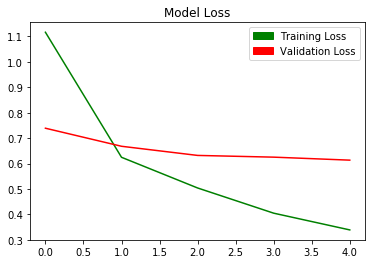

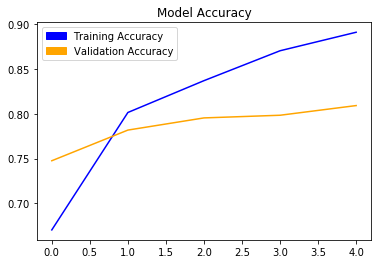

In [13]:
# PLOT COST AND ACCURACY OF MODEL
# COST
plt.figure(1)
plt.plot(trainCost, color='g', alpha=1)
plt.plot(validCost, color='r', alpha=1)
plt.title('Model Loss')
green = mpatches.Patch(color='green', label='Training Loss')
red = mpatches.Patch(color='red', label='Validation Loss')
plt.legend(handles=[green,red])
plt.show()
# ACCURACY
plt.figure(2)
plt.plot(trainAcc, color='b', alpha=1)
plt.plot(validAcc, color='orange', alpha=1)
plt.title('Model Accuracy')
blue = mpatches.Patch(color='b', label='Training Accuracy')
orange = mpatches.Patch(color='orange', label='Validation Accuracy')
plt.legend(handles=[blue,orange])
plt.show()